# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import shap


from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import preprocessing
from dataprep import dataprep

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)

dataprep = False
training = True
seed=42

# Functions


In [2]:
def MAPE(y_true, y_pred): 
    """Calculates the MAPE (mean absolute percentual error)"""
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    if any(y_true == 0):
        output = mean_absolute_error(y_true, y_pred)/ y_true.mean()
    else:
        output = np.mean(np.abs((y_true - y_pred) / y_true))       
    return output*100



def cat_encoding(df, cat_vars:str, encoding:str = 'label'):
    """Encodes cathegorical variables of a dataframe
    
    inputs
    df - dataframe that have variables to encode
    cat_vars - list of variables to encode
    encoding - encoding method (possible values are 'label' or 'one_hot')
    
    output
    df_out - outputs the modified dataframe (with the original columns replaced by the respective
            encoded ones)"""
    
    if encoding == 'label':
        df_cat = pd.DataFrame({col: df[col].astype('category').cat.codes for col in df[cat_vars]}, index=df.index)
        df_out = df.drop(cat_vars, axis=1).merge(df_cat,left_index = True,right_index=True)
    if encoding == 'one_hot':
        df_out = pd.get_dummies(df,columns = cat_vars)
        
    return df_out

# Loading Data

In [3]:
if dataprep:
    dataprep() # sumarizes all the months and do initial dataprep / creates the data.csv file


anac_df = pd.read_csv("data.csv", low_memory=False)
feriados = pd.read_csv("feriados.csv")

In [4]:
anac_df.shape

(3549883, 52)

In [5]:
anac_df.head()

,id_basica,sg_empresa_icao,nm_empresa,nm_pais,ds_tipo_empresa,ds_di,ds_grupo_di,ds_tipo_linha,ds_servico_tipo_linha,nr_etapa,nr_ano_partida_real,nm_semestre_partida_real,nm_trimestre_partida_real,hr_partida_real,dt_partida_real,nm_mes_partida_real,nr_mes_partida_real,nm_dia_semana_partida_real,nr_dia_partida_real,sg_iata_origem,nm_pais_origem,nm_regiao_origem,sg_uf_origem,nm_municipio_origem,nr_escala_destino,hr_chegada_real,dt_chegada_real,nm_mes_chegada_real,nr_mes_chegada_real,nm_dia_semana_chegada_real,nr_dia_chegada_real,sg_iata_destino,nm_pais_destino,nm_regiao_destino,sg_uf_destino,nm_municipio_destino,nr_assentos_ofertados,nr_passag_pagos,nr_passag_gratis,sg_equipamento_icao,lt_combustivel,km_distancia,nr_horas_voadas,kg_payload,kg_bagagem_livre,kg_bagagem_excesso,kg_carga_paga,kg_peso,nr_velocidade_media,nr_carga_paga_km,nr_ask,nr_rpk
0,12017235,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,REGULAR PREVISTO EM HOTRAN,REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,2,2016.0,1º SEMESTRE,1º TRIMESTRE,06:52:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,THE,BRASIL,NORDESTE,PI,TERESINA,NaN,08:23:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,REC,BRASIL,NORDESTE,PE,RECIFE,118,83,0,E195,3442,937.0,"1,52",16842,1100,6,77,7408,"616,393",72149,110566.0,77771.0
1,12017070,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,FRETAMENTO,NÃO REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,01:43:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,SSA,BRASIL,NORDESTE,BA,SALVADOR,NaN,02:37:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,IOS,BRASIL,NORDESTE,BA,ILHÉUS,70,0,0,AT72,684,225.0,"0,9",7435,0,0,0,0,"250,491",0,15750.0,0.0
2,12017071,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,FRETAMENTO,NÃO REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,02:58:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,IOS,BRASIL,NORDESTE,BA,ILHÉUS,NaN,04:51:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCZ,BRASIL,NORDESTE,AL,RIO LARGO,70,33,0,AT72,1392,687.0,"1,88",7390,592,0,0,3067,"365,32",0,48090.0,22671.0
3,12017072,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,FRETAMENTO,NÃO REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,05:15:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCZ,BRASIL,NORDESTE,AL,RIO LARGO,NaN,06:32:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,SSA,BRASIL,NORDESTE,BA,SALVADOR,70,0,0,AT72,911,468.0,"1,28",7535,0,0,0,150,"365,496",0,32760.0,0.0
4,12017082,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,EXTRA SEM HOTRAN,NÃO REGULAR,INTERNACIONAL MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,13:25:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,VCP,BRASIL,SUDESTE,SP,CAMPINAS,NaN,22:24:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCO,ESTADOS UNIDOS DA AMÉRICA,NaN,NaN,"ORLANDO, FLORIDA",266,260,6,A332,59747,6792.0,"8,98",49489,4665,0,619,25234,"756,301",4204250,1806670.0,1765920.0


In [6]:
feriados.shape

(57, 3)

In [7]:
feriados.head()

,data,fl_feriado,desc_feriado
0,2016-01-01,1,confraternização universal (feriado nacional)
1,2016-02-09,1,(terça-feira ) – Carnaval (ponto facultativo)
2,2016-02-10,1,(quarta-feira ) – Quarta-feira Cinzas (ponto...
3,2016-03-25,1,(sexta-feira ) – Paixão Cristo (feriado naci...
4,2016-04-21,1,(quinta-feira) – Tirantes (feriado nacional)


# Filter Route CGH - SDU

In [8]:
df_sp = anac_df.query("sg_iata_origem == 'CGH' & sg_iata_destino == 'SDU' & nr_passag_pagos != 0")

In [9]:
df_sp.shape

(79191, 52)

# Feature Engineering

## Holyday Variables

In [10]:
# creating variables for 1 and 2 days before a holiday

feriados['data_d1'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=1)).date()))
feriados['data_d2'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=2)).date()))
feriados['data_d3'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=3)).date()))

feriados['fl_feriado_d1'] = feriados.fl_feriado
feriados['fl_feriado_d2'] = feriados.fl_feriado
feriados['fl_feriado_d3'] = feriados.fl_feriado

In [11]:
feriados.head()

,data,fl_feriado,desc_feriado,data_d1,data_d2,data_d3,fl_feriado_d1,fl_feriado_d2,fl_feriado_d3
0,2016-01-01,1,confraternização universal (feriado nacional),2015-12-31,2015-12-30,2015-12-29,1,1,1
1,2016-02-09,1,(terça-feira ) – Carnaval (ponto facultativo),2016-02-08,2016-02-07,2016-02-06,1,1,1
2,2016-02-10,1,(quarta-feira ) – Quarta-feira Cinzas (ponto...,2016-02-09,2016-02-08,2016-02-07,1,1,1
3,2016-03-25,1,(sexta-feira ) – Paixão Cristo (feriado naci...,2016-03-24,2016-03-23,2016-03-22,1,1,1
4,2016-04-21,1,(quinta-feira) – Tirantes (feriado nacional),2016-04-20,2016-04-19,2016-04-18,1,1,1


In [12]:
# joins with df_sp
df_sp = df_sp.merge(feriados[['data','fl_feriado']], left_on='dt_partida_real', right_on='data', how = 'left')
df_sp = df_sp.merge(feriados[['data_d1','fl_feriado_d1']], left_on='dt_partida_real', right_on='data_d1', how = 'left')
df_sp = df_sp.merge(feriados[['data_d2','fl_feriado_d2']], left_on='dt_partida_real', right_on='data_d2', how = 'left')
df_sp = df_sp.merge(feriados[['data_d3','fl_feriado_d3']], left_on='dt_partida_real', right_on='data_d3', how = 'left')

In [13]:
# filling nulls
df_sp.fillna(0,inplace=True)

In [14]:
# droping variables

keep_list = ["dt_partida_real",
             "id_basica",
             "hr_partida_real",
             "nr_dia_partida_real",
             "nm_dia_semana_partida_real",
             "nm_mes_partida_real",
             "nr_mes_partida_real",
             "fl_feriado",
             "fl_feriado_d1",
             "fl_feriado_d2",
             "fl_feriado_d3",
             "hr_chegada_real",
             "nr_dia_chegada_real",
             "nm_dia_semana_chegada_real",
             "nr_ano_partida_real",
             "nr_assentos_ofertados",
             "nr_passag_pagos"]

df_sp = df_sp[keep_list]

In [15]:
# Changing names

df_sp.columns = ["departure_date",
             "id",
             "hr_departure",
             "departure_day_of_month",
             "departure_day_of_week",
             "departure_month",
             "departure_month_encoded",
             "fl_holiday",
             "fl_holiday_d1",
             "fl_holiday_d2",
             "fl_holiday_d3",
             "hr_arrival",
             "arrival_day_of_month",
             "arrival_day_of_week",
             "year",
             "n_seats_offered",
             "n_seats_paid"]

pt_eng = {'SEGUNDA-FEIRA': 'mon',
                 'TERÇA-FEIRA': 'tue',
                 'QUARTA-FEIRA': 'wed',
                 'QUINTA-FEIRA': 'thu',
                 'SEXTA-FEIRA': 'fri',
                 'SÁBADO': 'sat',
                 'DOMINGO': 'sun',
                 'JANEIRO' : 'jan',
                 'FEVEREIRO': 'feb',
                 'MARÇO': 'mar',
                 'ABRIL': 'apr',
                 'MAIO': 'may',
                 'JUNHO': 'jun',
                 'JULHO': 'jul',
                 'AGOSTO': 'aug',
                 'SETEMBRO': 'sep',
                 'OUTUBRO': 'oct',
                 'NOVEMBRO': 'nov',
                 'DEZEMBRO': 'dec'}

df_sp.replace(pt_eng, inplace = True)

In [16]:
df_sp.set_index("id",inplace = True)

In [17]:
df_sp.head()

,departure_date,hr_departure,departure_day_of_month,departure_day_of_week,departure_month,departure_month_encoded,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,hr_arrival,arrival_day_of_month,arrival_day_of_week,year,n_seats_offered,n_seats_paid
id,,,,,,,,,,,,,,,,
12018065,2016-01-02,14:40:00,2.0,sat,jan,1.0,0.0,0.0,0.0,0.0,15:58:00,2.0,sat,2016.0,118,64
12021813,2016-01-07,16:55:00,7.0,thu,jan,1.0,0.0,0.0,0.0,0.0,17:52:00,7.0,thu,2016.0,106,81
12023749,2016-01-09,14:40:00,9.0,sat,jan,1.0,0.0,0.0,0.0,0.0,16:13:00,9.0,sat,2016.0,118,78
12029256,2016-01-16,14:50:00,16.0,sat,jan,1.0,0.0,0.0,0.0,0.0,15:41:00,16.0,sat,2016.0,118,99
12034688,2016-01-23,14:47:00,23.0,sat,jan,1.0,0.0,0.0,0.0,0.0,15:41:00,23.0,sat,2016.0,118,104


## Hours 

In [18]:
# tranforming hours variables into bins of one hour interval
df_sp['hr_departure'] = df_sp.hr_departure.apply( lambda x : int(x[:2]))
df_sp['hr_arrival'] = df_sp.hr_arrival.apply( lambda x : int(x[:2]))

## Grouping Data into hourly bins

In [46]:
df_sp_grouped = df_sp.groupby(["departure_date",
                               "hr_departure",
                               "departure_day_of_month",
                               "departure_day_of_week",
                               "departure_month",
                               "fl_holiday",
                               "fl_holiday_d1",
                               "fl_holiday_d2",
                               "fl_holiday_d3",
                               "hr_arrival",
                               "arrival_day_of_month",
                               "arrival_day_of_week"]
).agg(n_seats_paid=('n_seats_paid', np.sum),
      n_seats_offered=('n_seats_offered', np.sum),
      frequency = ('hr_departure', 'count')).reset_index()


In [20]:
df_sp_grouped.shape

(31511, 15)

In [21]:
df_sp_grouped.head()

,departure_date,hr_departure,departure_day_of_month,departure_day_of_week,departure_month,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,hr_arrival,arrival_day_of_month,arrival_day_of_week,n_seats_paid,n_seats_offered,frequency
0,2016-01-01,8,1.0,fri,jan,1.0,0.0,0.0,0.0,8,1.0,fri,69,138,1
1,2016-01-01,8,1.0,fri,jan,1.0,0.0,0.0,0.0,9,1.0,fri,131,288,2
2,2016-01-01,9,1.0,fri,jan,1.0,0.0,0.0,0.0,10,1.0,fri,111,426,3
3,2016-01-01,10,1.0,fri,jan,1.0,0.0,0.0,0.0,11,1.0,fri,102,603,4
4,2016-01-01,11,1.0,fri,jan,1.0,0.0,0.0,0.0,12,1.0,fri,184,453,3


# EDA

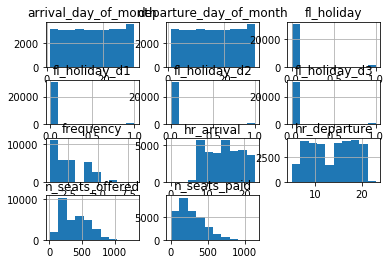

In [22]:
df_sp_grouped.hist();

## Moving Average

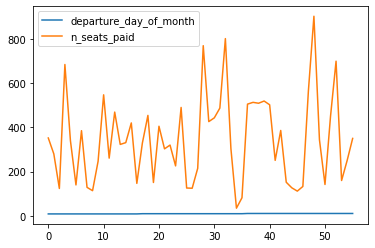

In [23]:
df_sp_grouped.query("'2019-10-09' <= departure_date <= '2019-10-11' ").reset_index()[['departure_day_of_month','n_seats_paid']].plot()

# Modeling One Hot Encoding

In [49]:
# Encoding days of the week and month variables
#df_sp_grouped.drop(['departure_date'],axis=1,inplace = True)

#cat_vars = df_sp_grouped.select_dtypes(include='object').columns.values.tolist()
cat_vars = [ 'departure_day_of_week', 'departure_month', 'arrival_day_of_week']
df_sp_grouped = cat_encoding(df_sp_grouped,cat_vars, encoding = 'one_hot')

In [50]:
df_sp_grouped.head()

,departure_date,hr_departure,departure_day_of_month,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,hr_arrival,arrival_day_of_month,n_seats_paid,n_seats_offered,frequency,departure_day_of_week_fri,departure_day_of_week_mon,departure_day_of_week_sat,departure_day_of_week_sun,departure_day_of_week_thu,departure_day_of_week_tue,departure_day_of_week_wed,departure_month_apr,departure_month_aug,departure_month_dec,departure_month_feb,departure_month_jan,departure_month_jul,departure_month_jun,departure_month_mar,departure_month_may,departure_month_nov,departure_month_oct,departure_month_sep,arrival_day_of_week_fri,arrival_day_of_week_mon,arrival_day_of_week_sat,arrival_day_of_week_sun,arrival_day_of_week_thu,arrival_day_of_week_tue,arrival_day_of_week_wed
0,2016-01-01,8,1.0,1.0,0.0,0.0,0.0,8,1.0,69,138,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2016-01-01,8,1.0,1.0,0.0,0.0,0.0,9,1.0,131,288,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2016-01-01,9,1.0,1.0,0.0,0.0,0.0,10,1.0,111,426,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2016-01-01,10,1.0,1.0,0.0,0.0,0.0,11,1.0,102,603,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2016-01-01,11,1.0,1.0,0.0,0.0,0.0,12,1.0,184,453,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [70]:
# Out of time set
X_oot = df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python').drop(['n_seats_paid'],axis=1)
y_oot = df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python').n_seats_paid

# Trains test split
X = df_sp_grouped[~df_sp_grouped["departure_date"].str.contains('2020-02')].drop(columns = ['n_seats_paid','departure_date'])
y = df_sp_grouped[~df_sp_grouped["departure_date"].str.contains('2020-02')].n_seats_paid

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [71]:
X.head()

,hr_departure,departure_day_of_month,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,hr_arrival,arrival_day_of_month,n_seats_offered,frequency,departure_day_of_week_fri,departure_day_of_week_mon,departure_day_of_week_sat,departure_day_of_week_sun,departure_day_of_week_thu,departure_day_of_week_tue,departure_day_of_week_wed,departure_month_apr,departure_month_aug,departure_month_dec,departure_month_feb,departure_month_jan,departure_month_jul,departure_month_jun,departure_month_mar,departure_month_may,departure_month_nov,departure_month_oct,departure_month_sep,arrival_day_of_week_fri,arrival_day_of_week_mon,arrival_day_of_week_sat,arrival_day_of_week_sun,arrival_day_of_week_thu,arrival_day_of_week_tue,arrival_day_of_week_wed
0,8,1.0,1.0,0.0,0.0,0.0,8,1.0,138,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,8,1.0,1.0,0.0,0.0,0.0,9,1.0,288,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,9,1.0,1.0,0.0,0.0,0.0,10,1.0,426,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,10,1.0,1.0,0.0,0.0,0.0,11,1.0,603,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,11,1.0,1.0,0.0,0.0,0.0,12,1.0,453,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Random Forests

### Random Search

In [28]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
    random_grid = {'bootstrap': [True, False],
                   'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
    
    
    random_grid = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
    
    # Fit the random search model
    random_grid.fit(X_train, y_train)
    
    print(random_grid.best_params_)
    
    rand_reg = random_grid.best_estimator_.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 46.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 103.5min finished


{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}


In [29]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,rand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,rand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, rand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, rand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, rand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, rand_reg.predict(X_test))**0.5))

train MAE: 13.62
test MAE: 37.69
train MAPE: 7.24%
test MAPE: 20.34%
train RMSE: 19.37
test RMSE: 53.41


### Grid Search

In [79]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)

    param_grid = {'n_estimators': [2000],
                  'min_samples_split': [2],
                  'min_samples_leaf': [1],
                  'max_features': ['sqrt'],
                  'max_depth': [60],
                  'bootstrap': [True]}

    grid = GridSearchCV(rf, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_rf = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/welberth/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-79-2dbd66a31d5d>", line 12, in <module>
    grid = GridSearchCV(rf, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
  File "/home/welberth/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py", line 687, in fit
    self._run_search(evaluate_candidates)
  File "/home/welberth/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py", line 1148, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/home/welberth/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py", line 666, in evaluate_candidates
    cv.split(X, y, groups)))
  File "/home/welberth/.local/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
  

KeyboardInterrupt: 

In [ ]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_rf.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_rf.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_rf.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_rf.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

## lightGBM

### Random Search

In [32]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)


lgbmrandom_grid = {
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'learning_rate': [0.01,0.05,0.1],
               'colsample_bytree' : [0.3,0.5,1],
               'num_leaves' : [20,30,40,50,60],
               'subsample' : [0.2,0.3,0.5,1] ,
               'reg_alpha' : [0,0.5,1,2],
               'min_child_samples': [1, 2, 4],
               'n_estimators': [1000, 1600, 1800, 2000, 2500, 3000,3500,4000,4500,5000]}


lgbmrandom_grid = RandomizedSearchCV(estimator = lg,
                                     param_distributions = lgbmrandom_grid,
                                     n_iter = 300,
                                     cv = 3,
                                     random_state=seed,
                                     scoring = "neg_mean_absolute_error")

# Fit the random search model
lgbmrandom_grid.fit(X_train, y_train)

print(lgbmrandom_grid.best_params_)

lgbmrand_reg = lgbmrandom_grid.best_estimator_.fit(X_train, y_train)

{'subsample': 0.3, 'reg_alpha': 0, 'num_leaves': 50, 'n_estimators': 5000, 'min_child_samples': 1, 'max_depth': 80, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [33]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,lgbmrand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,lgbmrand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, lgbmrand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, lgbmrand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, lgbmrand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, lgbmrand_reg.predict(X_test))**0.5))

train MAE: 8.74
test MAE: 31.38
train MAPE: 5.21%
test MAPE: 16.58%
train RMSE: 11.44
test RMSE: 44.74


### Grid Search

In [73]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)

if training:

    param_grid = {
               'max_depth': [30,45,50],
               'learning_rate': [0.05],
               'colsample_bytree' : [0.5],
               'num_leaves' : [50,55],
               'subsample' : [0.25,1] ,
               'reg_alpha' : [0,1.2],
               'min_child_samples': [1],
               'n_estimators': [4000,4500,4750]}

    grid = GridSearchCV(lg, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_lgb = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 30, 'min_child_samples': 1, 'n_estimators': 4500, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.25}


In [77]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_lgb.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_lgb.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_lgb.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_lgb.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_lgb.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_lgb.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 9.39
test MAE: 30.78
train MAPE: 5.58%
test MAPE: 16.18%
train RMSE: 12.21
test RMSE: 44.16
---------------
Out of Time MAE: 46.66
Out of Time MAPE: 32.37%
Out of Time RMSE: 67.65


# Modeling Label Encoding

In [36]:
# Encoding days of the week and month variables
#df_sp_grouped.drop(['departure_date'],axis=1,inplace = True)

cat_vars = df_sp_grouped.select_dtypes(include='object').columns.values.tolist()
df_sp_grouped = cat_encoding(df_sp_grouped,cat_vars, encoding = 'label')

In [37]:
X = df_sp_grouped.drop(['n_seats_paid'],axis=1)
y = df_sp_grouped.n_seats_paid

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [38]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)


lgbmrandom_grid = {
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'learning_rate': [0.01,0.05,0.1],
               'colsample_bytree' : [0.3,0.5,1],
               'num_leaves' : [20,30,40,50,60],
               'subsample' : [0.2,0.3,0.5,1] ,
               'reg_alpha' : [0,0.5,1,2],
               'min_child_samples': [1, 2, 4],
               'n_estimators': [1000, 1600, 1800, 2000, 2500, 3000,3500,4000,4500,5000]}


lgbmrandom_grid = RandomizedSearchCV(estimator = lg,
                                     param_distributions = lgbmrandom_grid,
                                     n_iter = 300,
                                     cv = 3,
                                     random_state=seed,
                                     scoring = "neg_mean_absolute_error")

# Fit the random search model
lgbmrandom_grid.fit(X_train, y_train)

print(lgbmrandom_grid.best_params_)

lgbmrand_reg = lgbmrandom_grid.best_estimator_.fit(X_train, y_train)

{'subsample': 0.3, 'reg_alpha': 0, 'num_leaves': 50, 'n_estimators': 5000, 'min_child_samples': 1, 'max_depth': 80, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [39]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,lgbmrand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,lgbmrand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, lgbmrand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, lgbmrand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, lgbmrand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, lgbmrand_reg.predict(X_test))**0.5))

train MAE: 8.74
test MAE: 31.38
train MAPE: 5.21%
test MAPE: 16.58%
train RMSE: 11.44
test RMSE: 44.74


# Importance of Variables

In [40]:
explainer = shap.TreeExplainer(reg_lgb, approximate = True)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [41]:

rf_shap_values = explainer.shap_values(X_test.iloc[0:1000,:])


#import matplotlib.pyplot as plt
#f = plt.figure()
#shap.summary_plot(rf_shap_values, X_test)

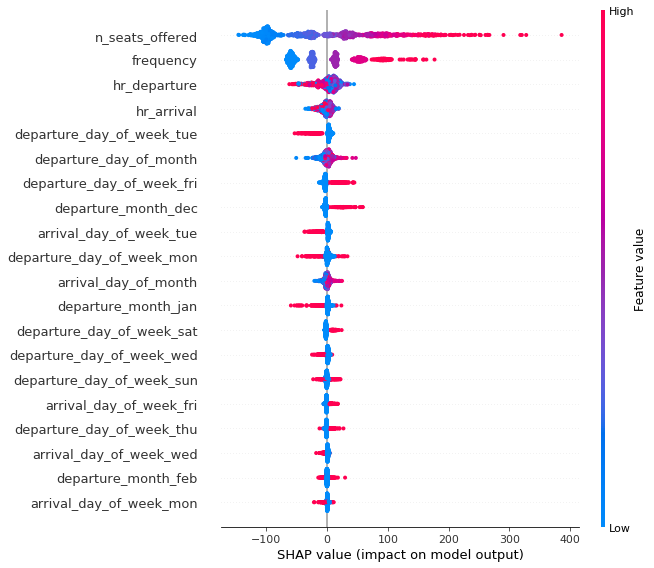

In [42]:
shap.summary_plot(rf_shap_values, X_test.iloc[0:1000,:])

In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value, rf_shap_values[10,:], X_test.iloc[10,:])

In [44]:
pred = 

SyntaxError: invalid syntax (<ipython-input-44-d23650372050>, line 1)